In [1]:
import os
import pickle
import multiprocessing
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, FastICA

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold, cross_val_predict

color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 100

from subprocess import check_output

from pyfm import pylibfm
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize

%load_ext autotime

/home/subaevdi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

feat_all = train.columns[2:]
feat_categ = train.dtypes.index[train.dtypes == 'object']
feat_numb = list(set(feat_all) - set(feat_categ))

train['test'] = 0
test['test'] = 1

df = pd.concat([train, test], axis=0)
y = train.y
df = df.drop(["ID", "y"], axis=1)
print("Train shape : ", train.shape)
print("Test shape : ", test.shape)

ix_train = df.test == 0
ix_test = df.test == 1

Train shape :  (4209, 379)
Test shape :  (4209, 378)
time: 417 ms


In [5]:
df['X0_le'] = LabelEncoder().fit_transform(df.X0)

time: 8.56 ms


In [9]:
gs = check_model(['X0_le'])

Fitting 5 folds for each of 99 candidates, totalling 495 fits
time: 1.04 s


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:    0.8s finished


Pipeline(steps=[('en', SGDRegressor(alpha=0.0005, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', n_iter=5, penalty='elasticnet', power_t=0.25,
       random_state=42, shuffle=True, verbose=0, warm_start=False))])

time: 2.63 ms


Переменные, которые сильнее всего разделяют средний y

In [7]:
predictors = ['X339', 'X236', 'X205', 'X204', 'X270', 'X167', 'X277', 'X278', 'X269', 'X29',
 'X232', 'X279', 'X263', 'X276', 'X328', 'X272', 'X166', 'X17', 'X382', 'X378',
 'X371', 'X108', 'X325', 'X136', 'X54', 'X76', 'X185', 'X162', 'X159', 'X310', 'X252']

time: 1.62 ms


In [8]:
def check_model(predictors):
    classifier = lambda: SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.0005,
        l1_ratio=0.15,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
    

    model = Pipeline(steps=[
        #('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.6, 0.7, 0.9, 1],
        'en__l1_ratio': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }
    #parameters = {
    #    'en__alpha': [0.00001, 0.0001],
    #    'en__l1_ratio': [0, 0.0001, 0.001]
    #}

    folder = KFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        model, 
        parameters,
        scoring='r2',
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(df[ix_train][predictors], 
                                  y)
    
    return grid_search

time: 15.6 ms


In [6]:
def pickle_check_model(predictors, model_file, bremove = False):
    model_file = './../tmp/' + model_file
    if bremove and os.path.isfile(model_file):
        print("Removing old file")
        os.remove(model_file)
    if not os.path.isfile(model_file):
        print("Make grid search...")
        model = check_model(predictors)

        with open(model_file, 'wb') as f:
            pickle.dump(model, f)
    else:
        with open(model_file, 'rb') as f:
            print("Load from file...")
            model = pickle.load(f)
    print(model.best_score_)
    print(model.best_params_)
    return model

time: 8.35 ms


In [7]:
t = pickle_check_model(predictors, '1_model.pkl')

Load from file...
0.132319948991
{'en__alpha': 1e-05, 'en__l1_ratio': 0}
time: 2.19 ms


In [8]:
t = pickle_check_model(predictors, '1.1_model.pkl')

Load from file...
0.132319948991
{'en__alpha': 1e-05, 'en__l1_ratio': 0}
time: 2.34 ms


In [10]:
n_comp = 5
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(df[ix_train][predictors])


time: 35.8 ms


In [11]:
feat_ica = ['ica_' + str(c) for c in np.arange(n_comp)]
df_tmp=pd.DataFrame(ica2_results_train, columns=feat_ica)
if np.any(train.columns.isin(feat_ica)):
    train = train.drop(feat_ica, axis=1)
train = pd.concat((train, df_tmp), axis=1)
train.shape
train.columns

del df_tmp

time: 12.7 ms


In [12]:
t = pickle_check_model(predictors + feat_ica, '2_model.pkl')

Load from file...
0.132328312484
{'en__alpha': 1e-05, 'en__l1_ratio': 0}
time: 2.54 ms


In [13]:
t = pickle_check_model(feat_ica, '3_model.pkl')

Load from file...
-0.00178350274056
{'en__alpha': 1e-05, 'en__l1_ratio': 0}
time: 2.14 ms


In [27]:
t = pickle_check_model(feat_numb, '4_model.pkl', bremove=False)

Removing old file
Make grid search...
Fitting 5 folds for each of 99 candidates, totalling 495 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 488 out of 495 | elapsed:   25.5s remaining:    0.4s


0.511579804396
{'en__alpha': 1e-05, 'en__l1_ratio': 1}
time: 26.1 s


[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed:   25.7s finished


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


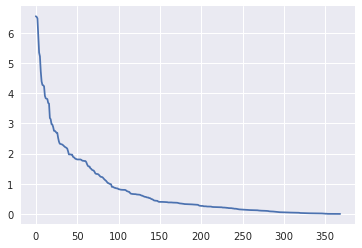

time: 244 ms


In [28]:
a = t.best_estimator_.steps[0][1]
df_tmp = pd.DataFrame({'col':feat_numb, 'val':a.coef_})
df_tmp['abs_val'] = np.abs(df_tmp.val)
df_tmp = df_tmp.sort_values('abs_val', ascending=False).reset_index()
plt.plot(df_tmp.abs_val)

feat_numb_top150 =list(df_tmp.col[:150])

In [87]:
def woker(p):
    f1 = p[0]
    f2 = p[1]
    nf = f1 + '_' + f2
    train[nf] = train[f1] * train[f2]
    return nf

numb_pairs = [(f1,f2) for f1, f2 in itertools.combinations(feat_numb_top150, r=2)][:50000]

#with multiprocessing.Pool() as pool: # default is optimal number of processes
#    feat_numb_pair = pool.map(woker, numb_pairs)

time: 8.51 ms


In [ ]:
#t = pickle_check_model(feat_numb_pair, '5_model.pkl')

1. Генерим пары по 200 штук
2. Добавляем в train
3. Запускаем модель из базовыйх + добавленные 100 раз
4. Находим лучшую

In [17]:
if not os.path.isfile('./../tmp/model_score_list.pkl'):
    with open('./../tmp/model_score_list.pkl', 'wb') as f:
        pickle.dump(model_score_list, f)
    with open('./../tmp/model_pairs_list.pkl', 'wb') as f:
        pickle.dump(model_pairs_list, f)
else:
    with open('./../tmp/model_pairs_list.pkl', 'rb') as f:
        print("Load from file...")
        model_pairs_list = pickle.load(f)
    with open('./../tmp/model_score_list.pkl', 'rb') as f:
        print("Load from file...")
        model_score_list = pickle.load(f)

Load from file...
Load from file...
time: 9.26 ms


Топ 10 индексов, R2 в массиве с парами:          scr
23  0.442851
10  0.436912
36  0.436789
40  0.436373
2   0.433045
38  0.430571
39  0.430131
30  0.429575
21  0.429495
32  0.428968


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


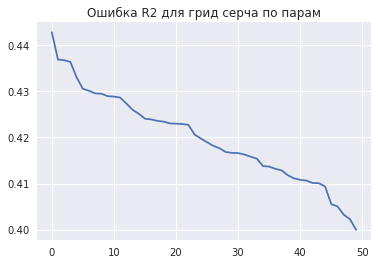

time: 224 ms


In [89]:
df_tmp = pd.DataFrame({'scr':model_score_list})
plt.plot(df_tmp.sort_values('scr', ascending=False).values)
plt.title("Ошибка R2 для грид серча по парам")
print("Топ 10 индексов, R2 в массиве с парами:", df_tmp.sort_values('scr', ascending=False).\
      head(10))

In [90]:
def woker_split(p_in):
    p = p_in.split("_")
    f1 = p[0]
    f2 = p[1]
    df[p_in] = df[f1] * df[f2]
    return p_in

top_index = df_tmp.sort_values('scr', ascending=False).\
      head(5).index
#for pairs_index in 
#_ = [woker_split(p) for p in model_pairs_list[pairs_index]]

feat_pairs_in_top = sum([model_pairs_list[ind] for ind in top_index], [])
feat_pairs_in_top = list(set(feat_pairs_in_top))

# Add pairs to train
_ = [woker_split(p) for p in feat_pairs_in_top]


time: 1.97 s


In [29]:
# Построим модель соеденив
m = pickle_check_model(feat_numb_top150 + feat_pairs_in_top, '7_model.pkl')

Load from file...
0.486810358613
{'en__alpha': 1e-05, 'en__l1_ratio': 1}
time: 2.77 ms


## Submit XGBoost
Сделаем сабмит по парам индесков.

In [ ]:
 ()# mmm, xgboost, loved by everyone ^-^
import xgboost as xgb

y_mean= np.mean(train.y)
# prepare dict of params for xgboost to run with
xgb_params = { 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.7,
    'min_child_weight': 25,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1,
    'tree_method':'hist',
    'seed':42
}


# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train[feat_numb_top150 + top_pairs], train.y)
dtest = xgb.DMatrix(test[feat_numb_top150 + top_pairs])

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=1500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

In [ ]:
y_test = model.predict(dtest)
res = pd.DataFrame({'ID':test.ID, 'y':y_test})
res.to_csv("../submit/xgb_feat_numb_top150_top_pairsLB0.54214.csv", index=False)

In [91]:
feat_list = feat_numb_top150 + top_pairs
n_comp = 10


# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca.fit(df[ix_train][feat_list])
pca2_df = pca.transform(df[feat_list])

# ICA
ica = FastICA(n_components=n_comp, random_state=42, max_iter = 600)
ica.fit(df[ix_train][feat_list])
ica2_df= ica.transform(df[feat_list])

# Append decomposition components to datasets
feat_pca = list()
feat_ica = list()
for i in range(1, n_comp+1):
    df['pca_' + str(i)] = pca2_df[:,i-1]
    df['ica_' + str(i)] = ica2_df[:,i-1]
    feat_pca.append('pca_' + str(i))
    feat_ica.append('ica_' + str(i))


NameError: name 'top_pairs' is not defined

time: 16.3 ms


In [ ]:
y_mean= np.mean(train.y)
# prepare dict of params for xgboost to run with
xgb_params = { 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.6,
    'min_child_weight': 25,
    'colsample_bytree': 0.6,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1,
    'tree_method':'hist',
    'seed':42
}


# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train[feat_pca + feat_ica], train.y)
dtest = xgb.DMatrix(test[feat_pca + feat_ica])

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=1500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

In [ ]:
m = pickle_check_model(feat_numb_top150 + model_pairs_list[23], '6_model.pkl')

In [ ]:
pairs_in_model = list()
for i in [23, 10, 36, 40, 2, 38, 39, 30, 21, 32]:
    a = m.best_estimator_.steps[0][1].coef_
    df_tmp = pd.DataFrame({'col':feat_numb_top150 + model_pairs_list[i], 'val':a})
    df_tmp['abs_val'] = np.abs(df_tmp.val)
    df_tmp = df_tmp.sort_values('abs_val', ascending=False).reset_index()
    pairs_in_model.append([x for x in df_tmp.col[:50] if '_' in x])
    #plt.plot(df_tmp.abs_val)
    #plt.title(str(i))
    #plt.show()
    

In [ ]:
a = sum(pairs_in_model, [])
feat_pairs_in_top = list(np.unique(a))

In [ ]:
m = pickle_check_model(feat_numb_top150 + feat_pairs_in_top, '7_model.pkl')

In [ ]:
m = pickle_check_model(feat_numb + pairs_in_top, '8_model.pkl')

In [ ]:
a = m.best_estimator_.steps[0][1].coef_
df_tmp = pd.DataFrame({'col':feat_numb + pairs_in_top, 'val':a})
df_tmp['abs_val'] = np.abs(df_tmp.val)
df_tmp = df_tmp.sort_values('abs_val', ascending=False).reset_index()

## Двух этапный SGD
1. Обучем SGD на feat_numb
2. Вычислим ошибку $$y_{err} = y - y_{hat}$$
3. Обучим $y_{pairs} = SGD(feat\_pairs, y_{err})$
4. Конченый прогноз
$$y_{end} = y_{hat} + y_{pairs} $$

$$y_{hat} =w_0 + w*X_{feat\_numb}, min(Error(y, y_{hat})) $$
$$y_{pairs} =z_0 + z*X_{feat\_pairs} , min(Error( y - y_{hat}, y_{pairs} ))$$

$$ y_{hat} + y_{pairs} = w_0 + w*X_{feat\_numb} + z_0 + z*X_{feat\_pairs} $$


In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
clf = SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=1e-05,
        l1_ratio=1,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
y_hat = cross_val_predict(clf, train[feat_numb], y=train.y, cv=kf)
r2_score(train.y, y_hat)

y_err = train.y - y_hat 

In [93]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder


for col in feat_categ:
    df[col] = LabelEncoder().fit_transform(df[col])
X = OneHotEncoder().fit_transform(df[feat_categ])


feat_ohe = ['ohe_' + str(i) for i in np.arange(X.shape[1])]
t = pd.DataFrame(X.todense(), columns=feat_ohe, index=df.index)
df_2 = pd.concat( [df, t] , axis=1)



t.shape, df.shape, df_2.shape

((8418, 211), (8418, 1768), (8418, 1979))

time: 316 ms


In [ ]:
df_2.columns

In [ ]:
y_mean= np.mean(y)
# prepare dict of params for xgboost to run with
xgb_params = { 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.8,
    'min_child_weight': 25,
    'colsample_bytree': 0.8,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1,
    'tree_method':'hist',
    'seed':42,
#    'gamma': 0.05,
    'alpha':0.3
}

tmp = normalize(df_2[feat_ohe + feat_numb + feat_ica])

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(tmp[ix_train], y)
dtest = xgb.DMatrix(tmp[ix_test])

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=1500, # increase to have better results (~700)
                   early_stopping_rounds=100,
                   verbose_eval=200, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

In [ ]:
cv_result.iloc[-1,2]

In [ ]:
df.index

In [ ]:
t = pd.DataFrame(X.todense())
# = pd.concat([df,t], axis=1)
t2.shape

In [ ]:
a = pd.concat([train,test], axis=0)
a.shape

In [ ]:



y_categ = cross_val_predict(clf, X, y=y_err, cv=kf)


In [ ]:
r2_score(train.y, y_categ + y_hat)

In [ ]:
def check_model2(X, y):
    classifier = lambda: SGDRegressor(
        loss='squared_loss',
        penalty='elasticnet',
        alpha=0.0005,
        l1_ratio=0.15,
        fit_intercept=True,
        n_iter=5,
        shuffle=True,
        verbose=0, epsilon=0.1, random_state=42, learning_rate='invscaling',
        eta0=0.01, power_t=0.25, warm_start=False, average=False)
    

    model = Pipeline(steps=[
        #('ss', StandardScaler()),
        ('en', classifier())
    ])

    parameters = {
        'en__alpha': [0.00001, 0.0001, 0.001, 0.01, 0.02, 0.1, 0.5, 0.6, 0.7, 0.9, 1],
        'en__l1_ratio': [0, 0.001, 0.01, 0.1, 0.3, 0.5, 0.75, 0.9, 1]
    }
    #parameters = {
    #    'en__alpha': [0.00001, 0.0001],
    #    'en__l1_ratio': [0, 0.0001, 0.001]
    #}

    folder = KFold(n_splits=5, shuffle=True, random_state=42)
    
    grid_search = GridSearchCV(
        model, 
        parameters,
        scoring='r2',
        cv=folder, 
        n_jobs=-1, 
        verbose=1)
    grid_search = grid_search.fit(X, y)
    
    return grid_search

In [ ]:
m = check_model2(X, y_err)

## FFM

time: 6.89 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
train = [
    {"user": "1", "item": "5", "age": 19},
    {"user": "2", "item": "43", "age": 33},
    {"user": "3", "item": "20", "age": 55},
    {"user": "4", "item": "10", "age": 20},
]
v = DictVectorizer()
X = v.fit_transform(train)
print(X.toarray())


y = np.repeat(1.0,X.shape[0])
fm = pylibfm.FM()
fm.fit(X,y)
fm.predict(v.transform({"user": "1", "item": "10", "age": 24}))


In [92]:
tmp = normalize(
    csr_matrix(df_2[ix_train][feat_numb_top150 + feat_pairs_in_top].astype(float))
)
X_train, X_test, y_train, y_test = train_test_split(tmp, np.array(y),
                                                    test_size=0.2, random_state = 42)


time: 267 ms


In [36]:
grid_search = {'num_factors':np.arange(1,11),
    'num_iter':[2,10,30,50,100],
    'initial_learning_rate':[0.001, 0.01]
    }
df_grid_res = pd.DataFrame(columns=['num_fac', 'num_iter', 'initial_learning_rate', 'r2'])
i = 0
for _num_factors, _num_iter, _initial_learning_rate  in itertools.product( *grid_search.values() ):
    fm = pylibfm.FM(num_factors=_num_factors,
                    num_iter=_num_iter,
                    verbose=False,
                    task="regression",
                    initial_learning_rate=_initial_learning_rate,
                    validation_size=0.01,
                    learning_rate_schedule="optimal")
    fm.fit(X_train, y_train)
    try:
        r2 = r2_score(y_test, fm.predict(X_test))
    except:
        print('Exception')
        r2 = np.Inf
    #print('_num_factors',_num_factors, '_num_iter', _num_iter, _initial_learning_rate, r2)
    print(i, r2)
    df_grid_res.loc[i,:] = [_num_factors, _num_iter, _initial_learning_rate, r2]
    i=i+1
    
#df_grid_res

_num_factors 1 _num_iter 2 0.001 0.475593144494
_num_factors 1 _num_iter 2 0.01 0.393411655344
_num_factors 1 _num_iter 10 0.001 0.536195544132
_num_factors 1 _num_iter 10 0.01 0.441352527222
_num_factors 1 _num_iter 30 0.001 0.530531658617
_num_factors 1 _num_iter 30 0.01 0.432089819451
_num_factors 1 _num_iter 50 0.001 0.534202621755
_num_factors 1 _num_iter 50 0.01 0.443459519193
_num_factors 1 _num_iter 100 0.001 0.535219453712
_num_factors 1 _num_iter 100 0.01 0.424165981271
_num_factors 2 _num_iter 2 0.001 0.495771406381
_num_factors 2 _num_iter 2 0.01 0.338617017313
_num_factors 2 _num_iter 10 0.001 0.460684388528
_num_factors 2 _num_iter 10 0.01 0.494094025908
_num_factors 2 _num_iter 30 0.001 0.474809820309
_num_factors 2 _num_iter 30 0.01 0.501676074092
_num_factors 2 _num_iter 50 0.001 0.515468683133
_num_factors 2 _num_iter 50 0.01 0.512112401949
_num_factors 2 _num_iter 100 0.001 0.532584219263
_num_factors 2 _num_iter 100 0.01 0.48852910494
_num_factors 3 _num_iter 2 0.00

,num_fac,num_iter,initial_learning_rate,r2
0,1,2,0.001,0.475593
1,1,2,0.01,0.393412
2,1,10,0.001,0.536196
3,1,10,0.01,0.441353
4,1,30,0.001,0.530532
5,1,30,0.01,0.43209
6,1,50,0.001,0.534203
7,1,50,0.01,0.44346
8,1,100,0.001,0.535219
9,1,100,0.01,0.424166


time: 31min 51s


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


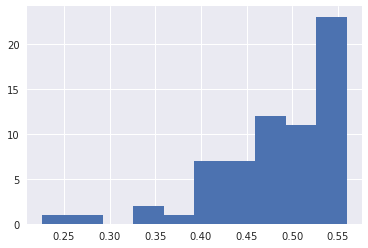

time: 234 ms


In [55]:
bind = df_grid_res.r2 != np.Inf
#plt.plot(df_grid_res[bind].sort_values("r2", ascending=False).r2.values, 'ro')
plt.hist(df_grid_res[bind].sort_values("r2", ascending=False).r2.values)
bind = (df_grid_res.r2 > 0.5) & (df_grid_res.r2 != np.Inf)
df_grid_FM_top = df_grid_res[bind]

In [37]:
df_grid_res

if not os.path.isfile('./../tmp/df_grid_res_FFM.pkl'):
    with open('./../tmp/df_grid_res_FFM.pkl', 'wb') as f:
        pickle.dump(df_grid_res, f)
else:
    with open('./../tmp/df_grid_res_FFM.pkl', 'rb') as f:
        print("Load from file...")

        df_grid_res = pickle.load(f)

time: 4.36 ms


In [110]:
df_grid_FM_top.shape[0]


array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

time: 4.18 ms


In [116]:
res_array = np.zeros((len(y), 30))
kf = KFold(n_splits=10, shuffle=True, random_state=42)
df_grid_FM_top['r2_kf'] = 0

i = 0
for ind, row  in df_grid_FM_top.iterrows():
    _num_factors = row['num_fac']
    _num_iter = row['num_iter']
    _initial_learning_rate = row['initial_learning_rate']
    res_cv = y.copy()
    res_cv[:] = np.mean(y)
    fm = pylibfm.FM(num_factors=_num_factors,
                        num_iter=_num_iter,
                        verbose=False,
                        task="regression",
                        initial_learning_rate=_initial_learning_rate,
                        validation_size=0.01,
                        learning_rate_schedule="optimal")

    for train_index, test_index in kf.split(tmp):
        X_train, X_test = tmp[train_index], tmp[test_index]
        y_train, y_test = y[train_index], y[test_index]
        #print(X_train.shape, X_test.shape)
        fm.fit(X_train, y_train)
        try:
            res_cv[test_index] = fm.predict(X_test)
        except:
            print("Prediction exception")
    
    df_grid_FM_top.loc[ind, 'r2_kf'] = r2_score(y, res_cv)
    res_array[:,i] = res_cv.values
    i = i + 1

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

time: 5min 47s


In [119]:
from polylearn import PolynomialNetworkRegressor

ModuleNotFoundError: No module named 'polylearn'

time: 17.9 ms


In [118]:
df_grid_FM_top

,num_fac,num_iter,initial_learning_rate,r2,r2_kf
2,1,10,0.001,0.536196,0.443154
4,1,30,0.001,0.530532,0.495203
6,1,50,0.001,0.534203,0.495952
8,1,100,0.001,0.535219,0.504397
15,2,30,0.01,0.501676,0.000000
16,2,50,0.001,0.515469,0.000000
17,2,50,0.01,0.512112,0.000000
18,2,100,0.001,0.532584,0.000000
22,3,10,0.001,0.546238,0.000000
24,3,30,0.001,0.5593,0.000000


time: 15.4 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


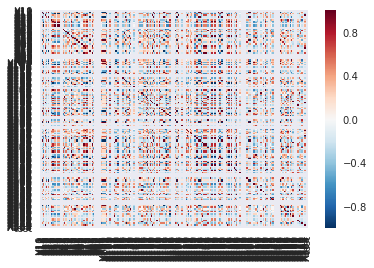

time: 13.6 s


In [129]:
#train.iloc[:10,10:]
import seaborn as sns
sns.heatmap(train.iloc[:10,10:].corr())

Index(['X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19',
       ...
       'X375', 'X376', 'X377', 'X378', 'X379', 'X380', 'X382', 'X383', 'X384',
       'X385'],
      dtype='object', length=368)

time: 3.06 ms


In [150]:
zero_count_list = []
one_count_list = []
cols_list = train.columns[10:][:-1]
for col in cols_list:
    zero_count_list.append((train[col]==0).sum())
    one_count_list.append((train[col]==1).sum())
feat_numb_all_zero = list(cols_list[(len(train) == np.array(zero_count_list))]); print(feat_numb_all_zero)
feat_numb_non_zero = list(set(feat_numb) -\
                          set(feat_numb_all_zero)
                         )

['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
time: 254 ms


In [151]:
feat_numb_all_zero

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

time: 2.57 ms


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


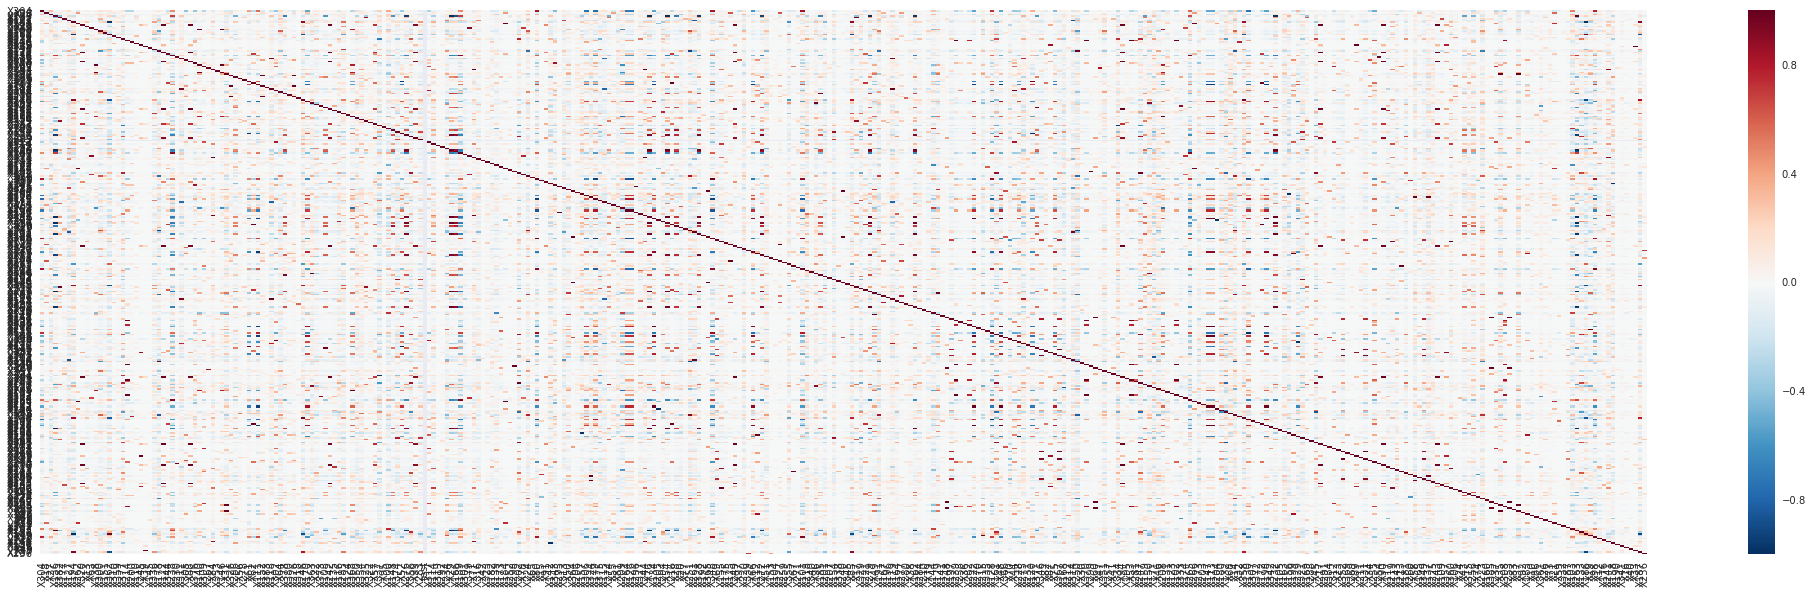

time: 14.7 s


In [162]:
m = train.loc[:,feat_numb_non_zero].corr()



/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


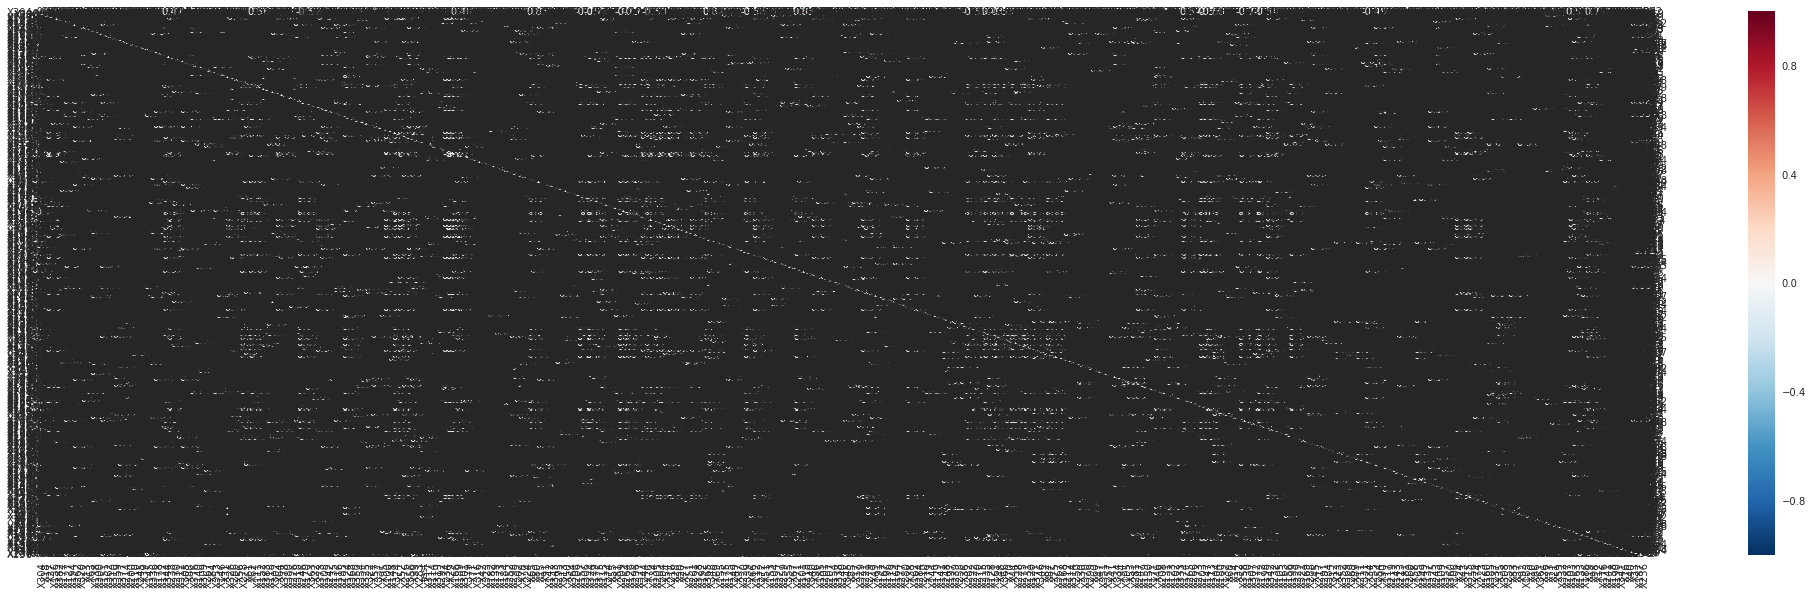

time: 14min 5s


In [170]:
plt.figure(figsize=(36,10))
sns.heatmap(m, annot = True)

In [167]:
from plotnine import *
from plotnine.data import *

time: 3.02 s


/home/subaevdi/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['xkcd', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


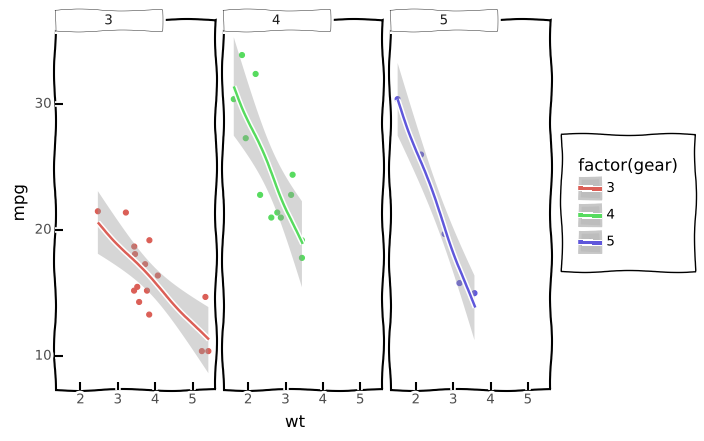

<ggplot: (-9223363289351121229)>

time: 982 ms


In [169]:
(ggplot(mtcars, aes('wt', 'mpg', color='factor(gear)'))
 + geom_point()
 + stat_smooth(method='lm')
 + facet_wrap('~gear')
 + theme_xkcd())